# NICE BUT UGLY IDEA

## The idea: train more times the last patient

In [1]:
%pylab inline
import pandas
import sklearn
import numpy

Populating the interactive namespace from numpy and matplotlib


Creating the arrays to store the data. The data will be stored so the index number corresponds to the patient number

In [2]:
number_of_patients = 5

features_patient = numpy.empty(number_of_patients+1, dtype = object)
label_patient    = numpy.empty(number_of_patients+1, dtype = object)

Loading and reading the Features Matrixes and the Labels.
For each one of them we control their form.

In [3]:
# Data directory:
data_directory = "ProcessedData/"

for pat_num in range(1, number_of_patients+1):
    file = open(data_directory + "dataMatrixS" + str(pat_num) + ".mat.csv")
    features_patient[pat_num] = numpy.loadtxt(file, delimiter=",")
    print("Shape features pat. " + str(pat_num) + ": " + str(shape(features_patient[pat_num])))


Shape features pat. 1: (1200, 152)
Shape features pat. 2: (1200, 152)
Shape features pat. 3: (1200, 152)
Shape features pat. 4: (1200, 152)
Shape features pat. 5: (1200, 152)


In [4]:
# Data directory:
data_directory = "preprocessed3/"

for pat_num in range(1, number_of_patients+1):
    file = open(data_directory + "targetsVectorS" + str(pat_num) + ".mat.csv")
    label_patient[pat_num] = numpy.loadtxt(file, delimiter=",")
    print("Shape labels pat. " + str(pat_num) + ": " + str(shape(label_patient[pat_num])))

Shape labels pat. 1: (1200,)
Shape labels pat. 2: (1200,)
Shape labels pat. 3: (1200,)
Shape labels pat. 4: (1200,)
Shape labels pat. 5: (1200,)


Stacking up the Matrix

In [5]:
# we are using 5 trials -> 5*16

trials = 5
epochs = 16

In [6]:
temp_features = features_patient[5][ : (trials*epochs), : ]

for i in range(14):
    temp_features = vstack((temp_features, features_patient[5][ : (trials*epochs), : ]))
print(shape(temp_features))

(1200, 152)


In [7]:
stacked_features = vstack((features_patient[1], features_patient[2]))

for i in range(3, number_of_patients):
    stacked_features = vstack((stacked_features, features_patient[i]))
print(shape(stacked_features))

stacked_features = vstack((stacked_features, temp_features))
print(shape(stacked_features))

(4800, 152)
(6000, 152)


In [8]:
temp_label = label_patient[5][ : (trials*epochs)]

for i in range(14):
    temp_label = hstack((temp_label, label_patient[5][ : (trials*epochs)]))
print(shape(temp_label))

(1200,)


In [9]:
stacked_label = hstack((label_patient[1], label_patient[2]))

for i in range(3, number_of_patients):
    stacked_label = hstack((stacked_label, label_patient[i]))
print(shape(stacked_label))

stacked_label = hstack((stacked_label, temp_label))
print(shape(stacked_label))

(4800,)
(6000,)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
stacked_features = scaler.fit_transform(stacked_features)

Freeing memory

In [11]:
import gc

In [12]:
del temp_features
del temp_label

gc.collect()

20

## LDA


### LDA with normal matrixes ###

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()

LDA.fit(stacked_features, stacked_label)

LinearDiscriminantAnalysis()

Score with the stacked matrixes

In [14]:
LDA.score(features_patient[5][ (trials*epochs): , : ], label_patient[5][ (trials*epochs): ])

0.7285714285714285

## Balancing the data

### Reducing the number of zeros ### <br>

For each 16 epochs, we remove 14 features rows labelled as 0, so the nuber of 0 and 1 is the same.


In [15]:
reduced_features = []
reduced_label = []

ratio = shape(stacked_label)[0] / epochs
for j in range(int(ratio)):
    number_of_zeros = 0
    for i in range(epochs):
        if stacked_label[i+(j*epochs)] == 1:
            reduced_features.append(stacked_features[i+(j*epochs)])
            reduced_label.append(stacked_label[i+(j*epochs)])
        elif stacked_label[i+(j*epochs)] == 0 and number_of_zeros < 2:
            reduced_label.append(stacked_label[i+(j*epochs)])
            reduced_features.append(stacked_features[i+(j*epochs)])
            number_of_zeros+=1

print(len(reduced_features))

1500


### Adding more ones ### <br>
For each feature row labelled 1, we add 6 almost identical rows, tweaked with some noise, so the number of 0 and 1 is the same. <br>
We found that a low value of noise produces the best score, but zero noise actually make it worse.

In [16]:

enlarged_features = stacked_features.copy()
enlarged_label = stacked_label.copy()

rows = shape(stacked_label)[0]
w = -1
for row in range(rows):
    if stacked_label[row] == 1:
        for i in range(6):
            w += 1
            enlarged_label = hstack((enlarged_label, 1))
            enlarged_features = vstack((enlarged_features, stacked_features[row]))
            for feature in range(152):
                #noise = 0
                noise = numpy.random.normal(0, .01)
                enlarged_features[rows + w][feature] += noise

print(len(enlarged_features))

10500


### LDA with the enlarged matrixes ###


In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()

LDA.fit(enlarged_features, enlarged_label)

LinearDiscriminantAnalysis()

Score on the whole dataset

In [18]:
LDA.score(stacked_features, stacked_label)

0.8481666666666666

Score on the last patient

In [20]:
LDA.score(features_patient[5][(trials*epochs) : , : ], label_patient[5][(trials*epochs) : ])

0.8285714285714286

### LDA with the reduced matrixes ###

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()

LDA.fit(reduced_features, reduced_label)

LinearDiscriminantAnalysis()

Score on the whole dataset

In [22]:
LDA.score(stacked_features, stacked_label)

0.7956666666666666

** Score on the last patient **

In [23]:
LDA.score(features_patient[5][(trials*epochs) : , : ], label_patient[5][(trials*epochs) : ])

0.7598214285714285

## SVM ##

In [24]:
from sklearn import svm, model_selection

model = svm.SVC(kernel='linear')
gammas = np.logspace(-5, 0.5, 20)
scores = []

for gamma in gammas:
    model.gamma = gamma
    s = model_selection.cross_val_score(model, reduced_features, reduced_label,
                                        cv=10, scoring='accuracy')
    scores.append(s.mean())

Best gamma: 1e-05
Best score: 0.8


Text(0, 0.5, 'Score (roc_auc)')

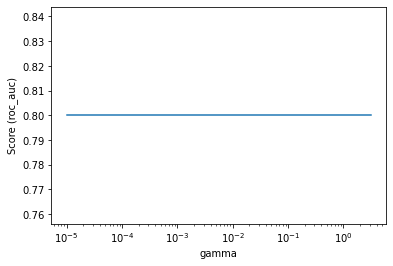

In [25]:
print ('Best gamma:', gammas[np.argmax(scores)])
print ('Best score:', scores[np.argmax(scores)])

semilogx(gammas, scores)
plt.xlabel('gamma')
plt.ylabel('Score (roc_auc)')

In [26]:
model = svm.SVC(kernel= 'linear')
model.fit(reduced_features, reduced_label)


SVC(kernel='linear')

In [27]:
model.score(stacked_features, stacked_label)

0.7985

In [28]:
model.score(features_patient[5][(epochs*trials) : , : ], label_patient[5][(epochs*trials) : ])

0.5285714285714286

In [29]:
predicted_labels = model.predict(features_patient[5][(epochs*trials) : , : ])

print("Shape: " + str(shape(predicted_labels)))
print(predicted_labels)

Shape: (1120,)
[0. 0. 0. ... 1. 1. 0.]


In [30]:
for r in label_patient[5].nonzero():
    print(str(r))

[   4    5   16   26   36   44   48   61   70   72   92   94  100  110
  114  121  129  135  152  154  162  172  189  190  202  203  209  212
  226  234  244  247  265  269  274  278  293  302  305  309  321  326
  344  349  356  366  372  380  384  395  401  409  423  430  435  439
  454  463  466  479  488  492  497  506  518  522  528  535  550  558
  564  575  580  589  592  604  608  616  625  626  643  655  662  669
  672  673  688  699  705  717  728  731  744  750  755  763  769  774
  795  798  802  808  820  826  832  845  860  861  876  878  882  889
  903  909  914  927  929  937  955  957  963  975  983  984  994  995
 1008 1021 1025 1031 1049 1055 1058 1071 1078 1080 1092 1096 1113 1116
 1121 1135 1140 1151 1160 1164 1170 1171 1194 1198]
